###Prepare parts

In [1]:
# !python -m pip install --upgrade pip --user
!pip install numpy
!pip install networkx
!pip install fuzzy-c-means
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [2]:
import numpy as np
import os
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans


from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
from sklearn import datasets
# from pyclustertend import ivat
from sklearn.preprocessing import scale

### Data prepare - self defined

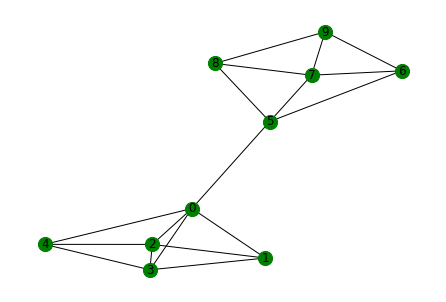

In [4]:

G_t1 = nx.star_graph(5)

G_t1.add_edge(1, 2)
G_t1.add_edge(1, 3)
G_t1.add_edge(2, 3)
G_t1.add_edge(3, 4)
G_t1.add_edge(2, 4)

G_t1.add_edge(5, 6)
G_t1.add_edge(5, 7)
G_t1.add_edge(5, 8)
G_t1.add_edge(6, 9)
G_t1.add_edge(7, 9)
G_t1.add_edge(7, 8)
G_t1.add_edge(6, 7)
G_t1.add_edge(9, 8)
# illustrate graph
nx.draw(G_t1, node_color = 'green', with_labels = True,
        node_size = 200)

### Graph SpecIVAT

In [14]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from numpy import linalg
import math
from scipy.linalg import fractional_matrix_power
from scipy.linalg import eigh


def specvat(data,k,name,return_odm=False, figure_size=(10, 10)):

    ordered_matrix, list_of_int = compute_ordered_dissimilarity_matrix(data,k)

    _, ax = plt.subplots(figsize=figure_size)
    ax.imshow(ordered_matrix, cmap='gray', vmin=0, vmax=np.max(ordered_matrix))

    if return_odm is True:
        return list_of_int,ordered_matrix


def i_specvat(data,k,name,return_odm=True, figure_size=(10, 10)):

    ordered_matrix,list_of_int = compute_ivat_ordered_dissimilarity_matrix(data,k)

    _, ax = plt.subplots(figsize=figure_size)
    ax.imshow(ordered_matrix, cmap='gray', vmin=0, vmax=np.max(ordered_matrix))
    ax.figure.savefig(name +'_img.png')

    return list_of_int,ordered_matrix

def dissimilarity(G,k):

    weight_matrix = np.zeros((G.number_of_nodes(),G.number_of_nodes()),dtype=float)
    diag_matrix = np.zeros((G.number_of_nodes(),G.number_of_nodes()),dtype=float)
    degree_matrix = np.zeros((G.number_of_nodes(),G.number_of_nodes()),dtype=float)
    diag_mat = np.identity(G.number_of_nodes(),dtype=float)

    lap_mat =diag_mat-nx.laplacian_matrix(G).A# 

    
    eig_values, eig_vacs = np.linalg.eigh(lap_mat)
    sort_values = np.argsort(eig_values)[::-1][:k]
    
    print(sort_values)
    eigvec_stack = []

    for i in range(k):
        eigvec_stack.append(eig_vacs[:, sort_values[i]])
 
    eigvec_stack = np.stack(eigvec_stack, axis=-1)
    dist_matrix = np.zeros((G.number_of_nodes(),G.number_of_nodes()),dtype=float)
    for m in range(G.number_of_nodes()):
        for n in range(G.number_of_nodes()):
            dist_matrix[m][n] = linalg.norm(eigvec_stack[m]-eigvec_stack[n])
    dist_matrix = dist_matrix/np.max(dist_matrix)
    # print(dist_matrix)
    return dist_matrix



def compute_ordered_dissimilarity_matrix(X,k):
    """The ordered dissimilarity matrix is used by visual assesement of tendency. It is a just a a reordering
    of the dissimilarity matrix.


    Parameters
    ----------

    X : matrix
        numpy array

    Return
    -------

    ODM : matrix
        the ordered dissimalarity matrix .

    """

    # Step 1 :

    observation_path = []

    # matrix_of_pairwise_distance = pairwise_distances(X)
    matrix_of_pairwise_distance = dissimilarity(X,k)
    # matrix_of_pairwise_distance = np.max(matrix_of_pairwise_distance)-matrix_of_pairwise_distance

    list_of_int = np.zeros(matrix_of_pairwise_distance.shape[0], dtype="int")

    index_of_maximum_value = np.argmax(matrix_of_pairwise_distance)

    column_index_of_maximum_value = index_of_maximum_value // matrix_of_pairwise_distance.shape[1]

    list_of_int[0] = column_index_of_maximum_value
    observation_path.append(column_index_of_maximum_value)


    # list_of_int[0] = arr_new[0]#column_index_of_maximum_value
    # observation_path.append(arr_new[0])#column_index_of_maximum_value)

    K = np.linspace(0, matrix_of_pairwise_distance.shape[0] - 1, matrix_of_pairwise_distance.shape[0], dtype="int")
    J = np.delete(K,column_index_of_maximum_value)

    # J = np.delete(K, arr_new[0])#column_index_of_maximum_value)

    # Step 2 :

    for r in range(1, matrix_of_pairwise_distance.shape[0]):
    # for r in arr_new[1:]:

        p, q = (-1, -1)

        mini = np.max(matrix_of_pairwise_distance)

        for candidate_p in observation_path:
            for candidate_j in J:
                if matrix_of_pairwise_distance[candidate_p, candidate_j] < mini:
                    p = candidate_p
                    q = candidate_j
                    mini = matrix_of_pairwise_distance[p, q]

        list_of_int[r] = q

        observation_path.append(q)

        ind_q = np.where(np.array(J) == q)[0][0]
        J = np.delete(J, ind_q)

    print(list_of_int)


    # Step 3

    ordered_matrix = np.zeros(matrix_of_pairwise_distance.shape)

    for column_index_of_maximum_value in range(ordered_matrix.shape[0]):
        for j in range(ordered_matrix.shape[1]):
            ordered_matrix[column_index_of_maximum_value, j] = matrix_of_pairwise_distance[
                list_of_int[column_index_of_maximum_value], list_of_int[j]]

    # Step 4 :

    return ordered_matrix, list_of_int




def compute_ivat_ordered_dissimilarity_matrix(X,k):
    """The ordered dissimilarity matrix is used by ivat. It is a just a a reordering
    of the dissimilarity matrix.


    Parameters
    ----------

    X : matrix
        numpy array

    Return
    -------

    D_prim : matrix
        the ordered dissimalarity matrix .

    """

    ordered_matrix, list_of_int = compute_ordered_dissimilarity_matrix(X,k)
    re_ordered_matrix = np.zeros((ordered_matrix.shape[0], ordered_matrix.shape[0]))
    re_list = list_of_int.copy()
    for r in range(1, ordered_matrix.shape[0]):
        # Step 1 : find j for which D[r,j] is minimum and j in [1:r-1]

        j = np.argmin(ordered_matrix[r, 0:r])

        # Step 2 :

        re_ordered_matrix[r, j] = ordered_matrix[r, j]
        re_ordered_matrix[j, r] = ordered_matrix[r, j]

        # Step 3 : pour c : 1,r-1 avec c !=j
        c_tab = np.array(range(0, r))
        c_tab = c_tab[c_tab != j]

        for c in c_tab:
            if re_ordered_matrix[j, c] > ordered_matrix[r, j]:
                re_list[c] = list_of_int[c]
            else:
                re_list[c] = list_of_int[r]
            re_ordered_matrix[r, c] = max(ordered_matrix[r, j], re_ordered_matrix[j, c])
            re_ordered_matrix[c, r] = re_ordered_matrix[r, c]
    print(list_of_int)
    return re_ordered_matrix,list_of_int


/usr/local/lib/python3.8/dist-packages/scipy/sparse/_base.py:742: VisibleDeprecationWarning: Please use `.todense()` instead
  warn(np.VisibleDeprecationWarning(


[9 8]
[4 3 1 2 0 5 6 7 8 9]
[9 8]
[4 3 1 2 0 5 6 7 8 9]
[4 3 1 2 0 5 6 7 8 9]


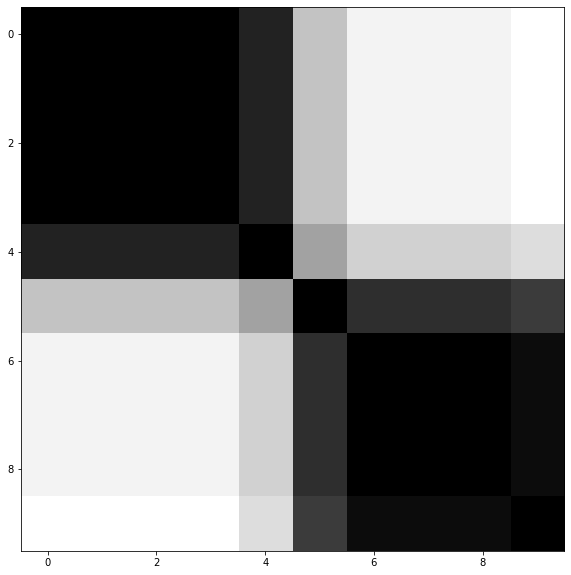

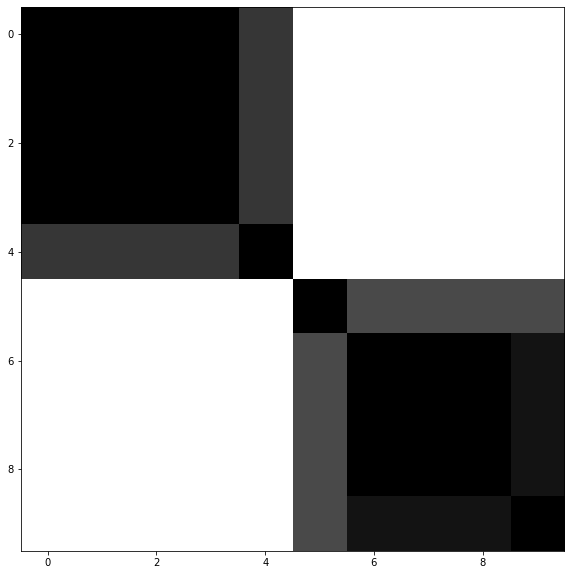

In [15]:

t1_d_2 = t1_m_2 = specvat(G_t1,2,'G_t1')

t1_d_2 = t1_m_2 = i_specvat(G_t1,2,'G_t1')